In [1]:
# to handle  data retrieval
import urllib3
from urllib3 import request
# to handle certificate verification
import certifi
# to manage json data
import json
# for pandas dataframes
import pandas as pd

In [2]:
http = urllib3.PoolManager(
       cert_reqs='CERT_REQUIRED',
       ca_certs=certifi.where())

In [3]:
# get weather observation data from the API, weather station 06041, located at [10.6316, 57.7364], all parameters, time period: april 1-9, 2021
url = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?stationId=06041&datetime=2021-04-01T00:00:00%2B02:00/2021-04-10T00:00:00%2B02:00&limit=300000&api-key=8d53e44d-970e-4cbb-a3ac-73f16df02b0e'
r = http.request('GET', url)
r.status

200

In [4]:
# decode json data into a dict object
data = json.loads(r.data.decode('utf-8'))
data

{'features': [{'geometry': {'coordinates': [10.6316, 57.7364],
    'type': 'Point'},
   'id': '026ba545-7c0a-2db4-2cee-b47467dae3c6',
   'properties': {'created': '2021-04-09T21:59:26.849455Z',
    'observed': '2021-04-09T22:00:00Z',
    'parameterId': 'temp_dry',
    'stationId': '06041',
    'value': 2.7},
   'type': 'Feature'},
  {'geometry': {'coordinates': [10.6316, 57.7364], 'type': 'Point'},
   'id': '22198b07-01fc-5586-5d1d-96c05373471c',
   'properties': {'created': '2021-04-09T21:59:26.852441Z',
    'observed': '2021-04-09T22:00:00Z',
    'parameterId': 'wind_max_per10min_past1h',
    'stationId': '06041',
    'value': 12.1},
   'type': 'Feature'},
  {'geometry': {'coordinates': [10.6316, 57.7364], 'type': 'Point'},
   'id': '2ce0c772-db7b-568b-5e08-22f5f7d9f1da',
   'properties': {'created': '2021-04-09T21:59:26.849062Z',
    'observed': '2021-04-09T22:00:00Z',
    'parameterId': 'temp_dew',
    'stationId': '06041',
    'value': -1.6},
   'type': 'Feature'},
  {'geometry': 

In [5]:
# in this dataset, the data to extract is under 'features'
df = pd.json_normalize(data, 'features')
df.head(5)
len(df)

23082

In [6]:
#drop the columns we are not insterested in
df_drop = df.drop(['geometry.coordinates', 'id', 'properties.created', 'properties.stationId', 'type', 'geometry.type'],
    axis=1,
)

In [7]:
#choose only rows with wind speed and wind direction 
wind_speed_dir = df_drop[df_drop['properties.parameterId'].isin(['wind_speed', 'wind_dir'])]

In [8]:
#check the output
wind_speed_dir.head(5)

,properties.observed,properties.parameterId,properties.value
15,2021-04-09T22:00:00Z,wind_speed,10.6
22,2021-04-09T22:00:00Z,wind_dir,273.0
34,2021-04-09T21:50:00Z,wind_speed,10.3
39,2021-04-09T21:50:00Z,wind_dir,272.0
47,2021-04-09T21:40:00Z,wind_speed,10.2


In [9]:
# we want wind speed and direction to be columns
pivot = wind_speed_dir.pivot_table('properties.value', ['properties.observed'], 'properties.parameterId')
pivot

properties.parameterId,wind_dir,wind_speed
properties.observed,,
2021-03-31T22:00:00Z,50.0,8.5
2021-03-31T22:10:00Z,49.0,9.0
2021-03-31T22:20:00Z,42.0,8.3
2021-03-31T22:30:00Z,42.0,8.2
2021-03-31T22:40:00Z,49.0,9.1
...,...,...
2021-04-09T21:20:00Z,270.0,12.0
2021-04-09T21:30:00Z,268.0,10.0
2021-04-09T21:40:00Z,267.0,10.2


In [10]:
!pip install windrose

In [11]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import base64

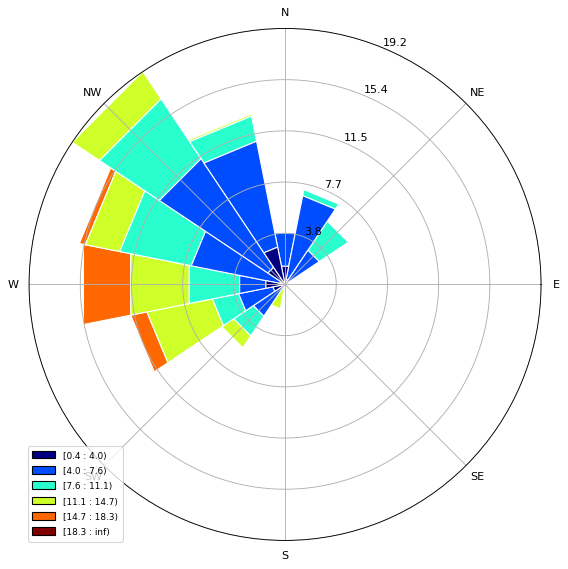

In [12]:
#Making a windrose from DMIs wind observations and saving it to .png
ax = WindroseAxes.from_ax()
ax.bar(pivot.wind_dir, pivot.wind_speed, normed=True, opening=1, edgecolor='white')
ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
ax.set_legend()

#provide a directory here to save as .png
plt.savefig('drive/MyDrive/windrose.png', dpi=30)
encoded = base64.b64encode(open('drive/MyDrive/windrose.png', 'rb').read()).decode()


In [15]:
import folium
from folium import IFrame

In [16]:
#centering the map to the location of our weather station
m = folium.Map(location=[57.7364, 10.6316], zoom_start=8, tiles="Stamen Terrain")
folium.Marker(
    location=[57.7364, 10.6316],
    popup="Weather station Skagen Fyr",
    icon=folium.Icon(icon="cloud"),
).add_to(m)
m

In [17]:
#adding the windrose to our weather station pop-up -ckick on it
html = '<img src="data:drive/MyDrive/test.png;base64,{}">'.format
iframe = IFrame(html(encoded),  width=270, height=270)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color='blue', icon='cloud')
marker = folium.Marker(location=[57.7364, 10.6316], popup=popup, icon=icon)
marker.add_to(m)
m

In [ ]:
m.save('drive/MyDrive/windrose_Skagen.html')